In [1]:
import json
import PIL as pil
import pandas as pd
import os
import sys
import random
import torch
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data
import numpy as np
import time
from PIL import Image
from tqdm import tqdm
import easydict
import time

import sys
import re
import six
import math
import torchvision.transforms as transforms

from utils import AttnLabelConverter, Averager, AlignCollate
import utils
from Trans import TPS_SpatialTransformerNetwork
import Trans
from Extract import RCNN_extractor
from Extract import EfficientNet
import Extract
from Seq import BidirectionalLSTM
import Seq
from Pred import Attention
import Pred
import torch.nn as nn
from torch.utils.data import *
from jamo import h2j, j2hcj
import gc

def json_loader(path):
    with open(path, 'r') as json_file:
        file = json.load(json_file)
    return file

def img_annot_split(label):
    label_images = pd.DataFrame(label['images'])
    label_annot = pd.DataFrame(label['annotations'])
    return label_images, label_annot

In [2]:
import importlib
importlib.reload(Trans)

<module 'Trans' from '/Data/FoodDetection/AI_OCR/Trans.py'>

### arguements

In [2]:
# opt
opt = easydict.EasyDict({
    "experiment_name" : 'first_0520',
    "manualSeed" : 1111,
    "imgH" : 35 ,
    "imgW" :  90,
    "PAD" : True ,
    'batch_size' : 256,
    'data_filtering_off' : True,
    'workers' : 20,
    'rgb' :True,
    'sensitive' : True,
    'character' : '0123456789ㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎㄵㄶㄺㄻㅀㄼㅄㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㅐㅒㅔㅖㅢㅟㅝㅞㅚㅘㅙ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' ,
    'batch_max_length' : 25,
    'num_fiducial' : 20,
    'output_channel' : 512,
    'hidden_size' :256,
    'lr' : 1,
    'rho' : 0.95,
    'eps' : 1e-8,
    'grad_clip' : 5,
    'valInterval' : 20,
    'num_iter' : 3000,
    'input_channel' : 3
    })

device = torch.device('cuda:1') #utils.py 안에 device는 따로 세팅해줘야함

In [3]:
# eff = EfficientNet()
# trans_output = torch.FloatTensor(10, 3, opt.imgH, opt.imgH)
# feature_output = eff(trans_output)
# feature_output.shape

### dataset

In [3]:
base_path = '/Data/KoreanSTR/'

# path_wild = '/Data/KoreanSTR/textinthewild_data_info.json'
# path_printed = '/Data/KoreanSTR/printed_data_info.json'
path_hand = '/Data/KoreanSTR/handwriting_data_info1.json'
# path_aug = '/Data/KoreanSTR/augmentation_data_info.json'

label_hand = json_loader(path_hand)
label_hand_images, label_hand_annot = img_annot_split(label_hand)

label_hand_annot = label_hand_annot[['id','text']]

dataset = '1_word'
file_list_word = os.listdir(os.path.join(base_path, dataset))
files_word = pd.DataFrame(file_list_word, columns=['file_name'])
files_word['id'] = files_word['file_name'].apply(lambda x : x.replace('.png',''))
files_labels = pd.merge(files_word, label_hand_annot, how='left', left_on='id',right_on='id' )

word_data = []
random_idx = np.random.choice(range(len(files_labels)), size= int(len(files_labels) * 1), replace=False)
for file in tqdm(files_labels.loc[random_idx]['file_name']):
#     img_arr = np.asarray(Image.open(os.path.join(base_path, dataset, file)))
    img_arr = Image.open(os.path.join(base_path, dataset, file))
    word_data.append(img_arr)
    
labels = [j2hcj(h2j(x)) for x in files_labels['text']]

Dataset = []
for img, text in zip(word_data, labels):
    Dataset.append((img, text))

100%|██████████| 359997/359997 [00:20<00:00, 17461.06it/s]


(194, 294, 3)


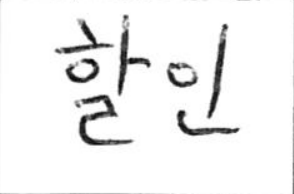

In [28]:
idx = 3000
print(np.array(Dataset[idx][0]).shape)
Dataset[idx][0]

In [4]:
_AlignCollate = utils.AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=True)
data_loader = DataLoader(Dataset[:int(len(Dataset)*0.9)], batch_size = opt.batch_size, shuffle=True, num_workers = 0, 
                         collate_fn = _AlignCollate,pin_memory=False )
data_loader_iter = iter(data_loader)

#for valid
_AlignCollate_valid = utils.AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=True)
valid_loader = DataLoader(Dataset[int(len(Dataset)*0.9) : ], batch_size = opt.batch_size, shuffle =True, num_workers=0, 
                          collate_fn=_AlignCollate_valid)

In [6]:
img, label = data_loader_iter.next()

In [7]:
img.shape

torch.Size([256, 3, 150, 450])

### model

In [5]:
class CTN(nn.Module):
    def __init__(self, opt):
        super(CTN, self).__init__()
        self.opt = opt
        
        #Trans
        self.Trans = Trans.TPS_SpatialTransformerNetwork(F = opt.num_fiducial,
                                                  i_size = (opt.imgH, opt.imgW), 
                                                  i_r_size= (opt.imgH, opt.imgW), 
                                                  i_channel_num=opt.input_channel,
                                                        device = device)
        #Extract
#         self.Extract = Extract.RCNN_extractor(opt.input_channel, opt.output_channel)
#         self.FeatureExtraction_output = opt.output_channel # (imgH/16 -1 )* 512
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None,1)) # imgH/16-1   ->  1
        self.Extract = EfficientNet()
        
        
         
        # Sequence
        self.Seq = nn.Sequential(
#             BidirectionalLSTM(self.FeatureExtraction_output, opt.hidden_size,  opt.hidden_size),
            BidirectionalLSTM(1536, opt.hidden_size,  opt.hidden_size),
            BidirectionalLSTM(opt.hidden_size, opt.hidden_size, opt.hidden_size))
        self.Seq_output = opt.hidden_size
        
        #Pred
        self.Pred = Pred.Attention(self.Seq_output, opt.hidden_size, opt.num_class, device=device)
        
        
    def forward(self, input, text, is_train=True):
        #Trans stage
        input = self.Trans(input)
        
        #Extract stage
        visual_feature = self.Extract(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))
        visual_feature = visual_feature.squeeze(3)
        
        #Seq stage
        contextual_feature = self.Seq(visual_feature)
        #Pred stage
        prediction = self.Pred(contextual_feature.contiguous(), text, is_train, batch_max_length = self.opt.batch_max_length)

        return prediction

In [ ]:
def train(opt):
    converter = AttnLabelConverter(opt.character)
    opt.num_class = len(converter.character)
    
    model = CTN(opt)
    print('model parameters. height {}, width {}, num of fiducial {}, input channel {}, output channel {}, hidden size {}, num class {},\
    batch max length {}'.format(opt.imgH, opt.imgW, opt.num_fiducial, opt.input_channel, opt.output_channel, opt.hidden_size, opt.num_class,
                               opt.batch_max_length))
    
    # weight initialization
    for name, param, in model.named_parameters():
        if 'localization_fc2' in name:
            print(f'Skip {name} as it is already initializaed')
            continue
        try:
            if 'bias' in name:
                init.constant_(param, 0.0)
            elif 'weight' in name:
                init.kaiming_normal_(param)
                
        except Exception as e :
            if 'weight' in name:
                param.data.fill_(1)
            continue
            
    #data parallel for multi GPU
#     model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)
    model.to(device)
    model.train()
    
    # loss
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device) #ignore [GO] token = ignore index 0
    log_avg = Averager()
    
    # filter that only require gradient descent
    filtered_parameters = []
    params_num = []
    for p in filter(lambda p : p.requires_grad, model.parameters()):
        filtered_parameters.append(p)
        params_num.append(np.prod(p.size()))
    print('Tranable params : ', sum(params_num))
    
    # optimizer
    optimizer = optim.Adadelta(filtered_parameters, lr= opt.lr, rho = opt.rho, eps = opt.eps)
    
    # opt log
    with open(f'./models/{opt.experiment_name}/opt.txt', 'a') as opt_file:
        opt_log = '---------------------Options-----------------\n'
        args = vars(opt)
        for k, v in args.items():
            opt_log +=f'{str(k)} : {str(v)}\n'
        opt_log +='---------------------------------------------\n'
        opt_file.write(opt_log)
        
    #start training
    start_iter = 0
    
    start_time = time.time()
    best_accuracy = -1
    best_norm_ED = -1
    i = start_iter
    
    while(True):
        image_tensors, labels = data_loader_iter.next()
        image = image_tensors.to(device)
        text, length = converter.encode(labels, batch_max_length = opt.batch_max_length)

        batch_size = image.size(0)
        

        preds = model(image, text[:, : -1])
        target = text[:, 1:]

        cost = criterion(preds.view(-1, preds.shape[-1]), target.contiguous().view(-1))
        
        loss_avg = Averager()
        
        model.zero_grad()
        cost.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), opt.grad_clip) #gradient clipping with 5
        optimizer.step()

        loss_avg.add(cost)

        #validation
        if i % opt.valInterval == 0:
            elapsed_time = time.time() - start_time
            with open(f'./models/{opt.experiment_name}/log_train.txt', 'a') as log:
                model.eval()
                with torch.no_grad():
                    valid_loss, current_accuracy, current_norm_ED, preds, confidence_score, labels, infer_time, length_of_data = utils.validation(
                        model, criterion, valid_loader, converter, opt)

                model.train()
                present_time = time.localtime()
                loss_log = f'[{i}/{opt.num_iter}] Train loss : {loss_avg.val():0.5f}, Valid loss : {valid_loss:0.5f}, Elapsed time : {elapsed_time:0.5f}, \
                Present time : {present_time[1]}/{present_time[2]}, {present_time[3]+9} : {present_time[4]}'
                loss_avg.reset()


                current_model_log = f'{"Current_accuracy":17s}: {current_accuracy:0.3f}, {"current_norm_ED":17s}: {current_norm_ED:0.2f}'


                #keep the best
                if current_accuracy > best_accuracy:
                    best_accuracy = current_accuracy
                    torch.save(model.state_dict(), f'./models/{opt.experiment_name}/best_accuracy.pth')

                if current_norm_ED > best_norm_ED:
                    best_norm_ED = current_norm_ED
                    torch.save(model.state_dict(), f'./models/{opt.experiment_name}/best_norm_ED.pth')

                best_model_log = f'{"Best accuracy":17s}: {best_accuracy:0.3f}, {"Best_norm_ED":17s}: {best_norm_ED:0.2f}'
                loss_model_log = f'{loss_log}\n{current_model_log}\n{best_model_log}'
                print(loss_model_log)
                log.write(loss_model_log+'\n')


                dashed_line = '-'*80
                head = f'{"Ground Truth":25s} | {"Prediction" :25s}| Confidence Score & T/F'
                predicted_result_log = f'{dashed_line}\n{head}\n{dashed_line}\n'

                for gt, pred, confidence in zip(labels[:5], preds[:5], confidence_score[:5]):
#                     if 'Attn' in opt.Prediction:
                    gt = gt[: gt.find('[s]')]
                    pred = pred[: pred.find('[s]')]

                    predicted_result_log += f'{gt:25s} | {pred:25s} | {confidence:0.4f}\t{str(pred == gt)}\n'
                predicted_result_log += f'{dashed_line}'
                print(predicted_result_log)
                log.write(predicted_result_log+'\n')


        if (i+1)% 1e+5 ==0:
            torch.save(model.state_dict(), f'./models/{opt.experiment_name}/iter_{i+1}.pth')


        if i==opt.num_iter:
            print('end of training')

        i +=1


In [ ]:
os.makedirs(f'./models/{opt.experiment_name}', exist_ok=True)

# set seed
random.seed(opt.manualSeed)
np.random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
torch.cuda.manual_seed(opt.manualSeed)

# set GPU
cudnn.benchmark = True
cudnn.deterministic = True
opt.num_gpu = torch.cuda.device_count()

if opt.num_gpu > 1:
    print('-------- Use multi GPU setting --------')
    opt.workers = opt.workers * opt.num_gpu
    opt.batch_size = opt.batch_size * opt.num_gpu
    
train(opt)

-------- Use multi GPU setting --------
model parameters. height 35, width 90, num of fiducial 20, input channel 3, output channel 512, hidden size 256, num class 91,    batch max length 25
Skip Trans.LocalizationNetwork.localization_fc2.weight as it is already initializaed
Skip Trans.LocalizationNetwork.localization_fc2.bias as it is already initializaed
Tranable params :  18293574
[0/3000] Train loss : 4.49904, Valid loss : 4.50357, Elapsed time : 2.66336,                 Present time : 5/21, 18 : 6
Current_accuracy : 0.000, current_norm_ED  : 0.01
Best accuracy    : 0.000, Best_norm_ED     : 0.01
--------------------------------------------------------------------------------
Ground Truth              | Prediction               | Confidence Score & T/F
--------------------------------------------------------------------------------
ㅋㅣㄹㄹㅗㄱㅡㄹㅐㅁ                | \\++++ㅊ??ㅊ?<ㅈ8ㄺ=ㄶ/ㅉ171ㅒ+ㅊ | 0.0000	False
ㅈㅜㅁㅜㄴ                     | \\++++ㅊ??ㅊ?<ㅈ8ㄺ=ㄶ/ㅉ171ㅒ+ㅊ | 0.0000	False
ㅈㅏㅈㅓㄴㄱㅓ        

[180/3000] Train loss : 4.21548, Valid loss : 4.24809, Elapsed time : 1299.55713,                 Present time : 5/21, 18 : 27
Current_accuracy : 0.000, current_norm_ED  : 0.00
Best accuracy    : 0.000, Best_norm_ED     : 0.08
--------------------------------------------------------------------------------
Ground Truth              | Prediction               | Confidence Score & T/F
--------------------------------------------------------------------------------
ㅅㅜㅋㅓㅅ                     |                           | 0.0000	False
ㅈㅏㅇㅇㅐㅇㅣㄴ                  |                           | 0.0000	False
ㅍㅜㅁㄷㅏ                     |                           | 0.0000	False
ㅈㅜㅇㅇㅛㅎㅏㄷㅏ                 |                           | 0.0000	False
ㅇㅛㅇㅅㅓㅎㅏㄷㅏ                 |                           | 0.0000	False
--------------------------------------------------------------------------------
[200/3000] Train loss : 4.17933, Valid loss : 4.21072, Elapsed time : 1449.74043,                 Present t

In [ ]:
converter = AttnLabelConverter(opt.character)
image = img.to(device)
text, length = converter.encode(label, batch_max_length = opt.batch_max_length)
batch_size = image.size(0)

In [ ]:
preds = model(image, text[:, : -1])
target = text[:, 1:]
# cost = criterion(preds.view(-1, preds.shape[-1]), target.contiguous().view(-1))

In [21]:
converter = AttnLabelConverter(opt.character)
opt.num_class = len(converter.character)
model = CTN(opt)

In [17]:
model = model.to('cpu')

In [22]:
test = torch.FloatTensor(1, 3, opt.imgH, opt.imgW).fill_(0)

In [23]:
test_output = model.Trans(test)

RuntimeError: CUDA error: out of memory

In [21]:
test_output.shape

torch.Size([192, 3, 35, 90])

In [22]:
extract_output = model.Extract(test_output)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [23]:
extract_output.shape

torch.Size([192, 512, 1, 23])

In [24]:
visual_feature = torch.FloatTensor(10, 512, 1, 23)

In [26]:
visual_feature_ = visual_feature.permute(0, 3, 1,2)

In [28]:
visual_feature_.squeeze_(3)

tensor([[[ 4.9792e-40,  1.7541e+19,  5.1695e+07,  ...,  5.6938e-39,
           1.7279e-41,  0.0000e+00],
         [ 0.0000e+00,  1.8754e+28,  2.7347e+20,  ...,  1.4372e-41,
           3.5816e-39,  1.9411e-41],
         [ 6.4304e-39,  6.9146e+28,  1.6244e+19,  ...,  0.0000e+00,
           0.0000e+00,  5.9693e-39],
         ...,
         [ 6.6814e-07,  1.6244e+19,  6.8589e+22,  ...,  0.0000e+00,
           0.0000e+00,  5.9694e-39],
         [ 1.9209e+31,  1.7443e+28,  1.5435e+25,  ...,  0.0000e+00,
           0.0000e+00,  1.5829e-41],
         [ 4.8403e+30,  3.5561e-09,  5.1694e+07,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 2.6457e-42,  0.0000e+00,  0.0000e+00,  ...,  1.5246e-42,
           9.0678e-42,  1.4586e-39],
         [ 0.0000e+00,  5.1568e-43,  0.0000e+00,  ...,  7.5232e-37,
           1.3677e-42, -2.2656e+38],
         [ 2.1204e-41,  0.0000e+00,  0.0000e+00,  ...,  1.4586e-39,
           7.5232e-37,  3.5733e-43],
         ...,
         [ 2.2248e-41,  0

In [29]:
visual_feature_.shape

torch.Size([10, 23, 512])